In [99]:
# 出走馬について上位に入る確率を予想し、確率が閾値以上の場合に限り購入することを考える
# 閾値を使わずに購入した場合と閾値以上の場合で比較し、的中率や回収率が改善されるか確認する

In [7]:
# インポート
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

In [9]:
# CSVファイルの読み込み
df = pd.read_csv('input_編集後_説明変数追加.csv', encoding='cp932')
print(f"dfの行数は {len(df)} ")
df['race_date'] = pd.to_datetime(df['race_date'])  # 日付が文字列なら変換
# フィルタ条件を適用
filtered_df = df[
    (df['race_date'].dt.year >= 2023) &
    (df['race_date'].dt.year <= 2024)
]
print(f"filtered_dfの行数は {len(filtered_df)} ")
# レースID、馬番順に並び替え
filtered_df = filtered_df.sort_values(by=['race_id', 'horse_number'])

dfの行数は 14488 
filtered_dfの行数は 9704 


In [11]:
# ---------- 説明変数 ----------------------------
features = [
    'time_index_diff_from_avg',
    'conditional_place_rate_diff_from_avg',
    'jockey_place_rate_diff_from_avg',
]
# ---------- リーク防止のラベル一括作成 ----------
# 上位4頭 → is_top4
filtered_df['is_top4'] = (
    filtered_df.groupby('race_id')['finish_rank']
    .rank(method='first') <= 4
).astype(int)

filtered_df.to_csv('C:\\Users\\ryo\\Downloads\\filtered_df.csv', index=False, encoding='cp932')

# ---------- モデル1 ----------
df_m1 = filtered_df.copy()

# ---------- 各モデルの特徴量と目的変数 ----------
X_m1 = df_m1[features]
y_m1 = df_m1['is_top4']

X_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_m1.csv', index=False, encoding='cp932')
y_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_m1.csv', index=False, encoding='cp932')

# ---------- モデル1の学習 ----------
X_train_m1 = X_m1[df_m1['race_date'].dt.year == 2023]
y_train_m1 = y_m1[df_m1['race_date'].dt.year == 2023]
X_val_m1   = X_m1[df_m1['race_date'].dt.year == 2024]
y_val_m1   = y_m1[df_m1['race_date'].dt.year == 2024]

base_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

model1 = xgb.XGBClassifier(
    **base_params,
    max_depth=3,
    learning_rate=0.06,
    n_estimators=100,
    reg_alpha=0.5,
    reg_lambda=1.0
)
model1.fit(X_train_m1, y_train_m1)

X_train_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_train_m1.csv', index=False, encoding='cp932')
y_train_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_train_m1.csv', index=False, encoding='cp932')
X_val_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_val_m1.csv', index=False, encoding='cp932')
y_val_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_val_m1.csv', index=False, encoding='cp932')

# ============================================================
# ✅ 推論フェーズ（レース単位で順にモデルを適用して1着を予測）
# ============================================================

# 対象とする検証データのみ（例：2024年）
df_test = filtered_df[filtered_df['race_date'].dt.year == 2024].copy()

# 結果格納リスト
full_predictions = []

for race_id, group in df_test.groupby('race_id'):

    # ---------- モデル1 ----------
    group_m1 = group.copy()
    X_test_m1 = group_m1[features]
    group_m1['pred_prob_m1'] = model1.predict_proba(X_test_m1)[:, 1]
    # 上位4頭を選出
    group_m1 = group_m1.sort_values('pred_prob_m1', ascending=False)
    group_m1['selected_in_m1'] = 0
    group_m1.iloc[:4, group_m1.columns.get_loc('selected_in_m1')] = 1

    # ✅ finish_rank も含めて出力
    result_cols = [
        'race_id', 'horse_number', 'finish_rank', 'popularity', 'odds', 'pred_prob_m1', 'selected_in_m1'
    ] + features

    full_predictions.append(group_m1[result_cols])

# 全レース結合
full_pred_df = pd.concat(full_predictions, ignore_index=True)

# CSV出力
full_pred_df.to_csv('C:\\Users\\ryo\\Downloads\\race_predictions_all_stages.csv', index=False, encoding='cp932')

print("finish_rank を含めた全段階の予測結果CSVを出力しました。")

### モデルの評価 ###

# モデル1
m1_preds = full_pred_df[full_pred_df['selected_in_m1'] == 1]
m1_total = len(m1_preds)
m1_hits = (m1_preds['finish_rank'] <= 4).sum()
m1_accuracy = m1_hits / m1_total if m1_total > 0 else 0

# 出力
print("▼ モデル1（上位4頭予測）の的中率")
print(f"  予測数: {m1_total}, 的中数: {m1_hits}, 的中率: {m1_accuracy:.4f}（{m1_accuracy:.2%}）\n")

# CSV出力
full_pred_df.to_csv('C:\\Users\\ryo\\Downloads\\full_pred_df.csv', index=False, encoding='cp932')

C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:57:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


finish_rank を含めた全段階の予測結果CSVを出力しました。
▼ モデル1（上位4頭予測）の的中率
  予測数: 2460, 的中数: 1691, 的中率: 0.6874（68.74%）



C:\Users\ryo\AppData\Local\Temp\ipykernel_3772\1304129656.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pop3.groupby('prob_bin')
C:\Users\ryo\AppData\Local\Temp\ipykernel_3772\1304129656.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pop3.groupby('prob_bin')
C:\Users\ryo\AppData\Local\Temp\ipykernel_3772\1304129656.py:49: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_3772\1304129656.py:49: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  p

▼ 3番人気馬の予測勝率と実際の的中率（ビン分け）
  prob_bin  サンプル数  的中数  的中率（%）
0  0.0–0.1      3    0    0.00
1  0.1–0.2     82    0    0.00
2  0.2–0.3    110    5    4.55
3  0.3–0.4    125    5    4.00
4  0.4–0.5    138    2    1.45
5  0.5–0.6     91    9    9.89
6  0.6–0.7     39    2    5.13
7  0.7–0.8     19    0    0.00
8  0.8–0.9      7    1   14.29
9  0.9–1.0      1    0    0.00


C:\Users\ryo\AppData\Local\Temp\ipykernel_3772\1304129656.py:49: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_3772\1304129656.py:49: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_3772\1304129656.py:49: UserWarning: Glyph 30058 (\N{CJK UNIFIED IDEOGRAPH-756A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_3772\1304129656.py:49: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_3772\1304129656.py:49: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_3772\1304129656.py:49: UserWarning: Glyph 39340 (\N{CJK UNIFIED IDEO

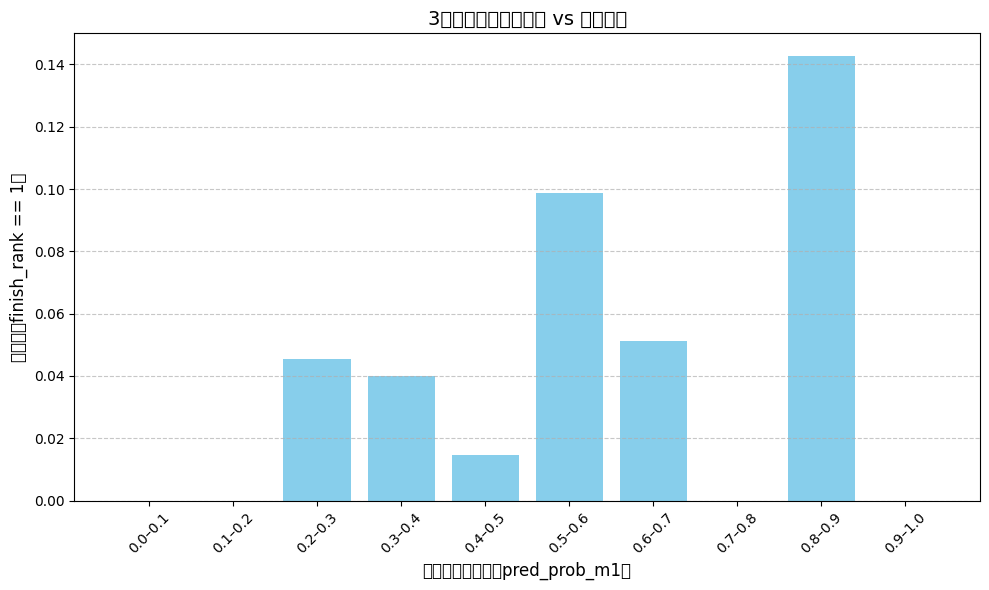

In [13]:
### 検証：probが閾値を超える場合に限り購入した場合、的中率や回収率が改善されるか確認する
### 条件：各人気ごとに確認する
###   例：3番人気の馬のprobが高いときに的中率と回収率が改善されるか
### 結論：改善される！

# 1. 3番人気の馬のみ抽出
df_pop3 = full_pred_df[full_pred_df['popularity'] == 6].copy()

# 2. pred_prob_m1 をビン分け（0.0〜1.0を0.1刻みで10区間に）
bins = np.arange(0, 1.01, 0.1)
labels = [f'{round(bins[i],2)}–{round(bins[i+1],2)}' for i in range(len(bins)-1)]
df_pop3['prob_bin'] = pd.cut(df_pop3['pred_prob_m1'], bins=bins, labels=labels, include_lowest=True)

# 各ビンごとにサンプル数・的中数・的中率を集計
bin_stats = (
    df_pop3.groupby('prob_bin')
    .agg(
        サンプル数=('finish_rank', 'count'),
        的中数=('finish_rank', lambda x: (x == 1).sum())
    )
    .reset_index()
)

# 的中率（パーセント表記）を追加
bin_stats['的中率（%）'] = (bin_stats['的中数'] / bin_stats['サンプル数'] * 100).round(2)

# 表を表示
print("▼ 3番人気馬の予測勝率と実際の的中率（ビン分け）")
print(bin_stats)

# 3. 各ビンごとの的中率（finish_rank == 1）を計算
bin_stats = (
    df_pop3.groupby('prob_bin')
    .agg(
        count=('finish_rank', 'count'),
        hits=('finish_rank', lambda x: (x == 1).sum())
    )
)
bin_stats['hit_rate'] = bin_stats['hits'] / bin_stats['count']

# 4. グラフ表示
plt.figure(figsize=(10, 6))
plt.bar(bin_stats.index.astype(str), bin_stats['hit_rate'], color='skyblue')
plt.xlabel('予測勝率の範囲（pred_prob_m1）', fontsize=12)
plt.ylabel('的中率（finish_rank == 1）', fontsize=12)
plt.title('3番人気馬の予測勝率 vs 実的中率', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [145]:
### 検証：probが閾値を超える場合に限り購入した場合、的中率や回収率が改善されるか確認する
### 条件：各人気ごとに確認する。また、一緒に走る馬のprobが低いことも条件に加える
###   例：「3番人気の馬のprobが高い」かつ「1番人気のprobが低い」ときに的中率と回収率が改善されるか
### 結論：改善される！

# 設定値（検証対象の人気と閾値）
target_popularity = 7
compared_popularity = 1
target_threshold = 0.7
compared_threshold = 0.7

# 1. 指定人気の馬だけ抽出
target_df = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# 2. 比較対象人気（例：1番人気）の予測確率を取得
compared_probs = (
    full_pred_df[full_pred_df['popularity'] == compared_popularity]
    .loc[:, ['race_id', 'pred_prob_m1']]
    .rename(columns={'pred_prob_m1': f'pop{compared_popularity}_prob'})
)

# 3. マージ
target_df = target_df.merge(compared_probs, on='race_id', how='left')

# 4. 条件でフィルタ
filtered_df = target_df[
    (target_df['pred_prob_m1'] >= target_threshold) &
    (target_df[f'pop{compared_popularity}_prob'] <= compared_threshold)
].copy()

# 5. 的中率・回収率
filtered_df['hit'] = (filtered_df['finish_rank'] == 1).astype(int)
bet_count = len(filtered_df)
hit_count = filtered_df['hit'].sum()
hit_rate = hit_count / bet_count if bet_count > 0 else 0
return_sum = filtered_df.loc[filtered_df['hit'] == 1, 'odds'].sum()
roi = return_sum / bet_count if bet_count > 0 else 0

# 6. 動的print文（ここが修正箇所）
print(f"▼ 条件：{target_popularity}番人気の予測確率 >= {target_threshold} ＆ "
      f"{compared_popularity}番人気の予測確率 <= {compared_threshold}")
print(f"  購入数: {bet_count}")
print(f"  的中数: {hit_count}")
print(f"  的中率: {hit_rate:.4f}（{hit_rate:.2%}）")
print(f"  回収率: {roi:.4f}（{roi:.2%}）")

# 必要ならCSV出力
filtered_df.to_csv(f'C:\\Users\\ryo\\Downloads\\pop{target_popularity}_high_pop{compared_popularity}_low.csv', index=False, encoding='cp932')


▼ 条件：7番人気の予測確率 >= 0.7 ＆ 1番人気の予測確率 <= 0.7
  購入数: 8
  的中数: 0
  的中率: 0.0000（0.00%）
  回収率: 0.0000（0.00%）


In [ ]:
### 出力メモ

# ▼ 条件：3番人気の予測確率 >= 0.7 ＆ 1番人気の予測確率 <= 0.6
#   購入数: 33
#   的中数: 14
#   的中率: 0.4242（42.42%）
#   回収率: 1.9576（195.76%）

# ▼ 条件：4番人気の予測確率 >= 0.6 ＆ 1番人気の予測確率 <= 0.6
#   購入数: 39
#   的中数: 6
#   的中率: 0.1538（15.38%）
#   回収率: 1.2590（125.90%）

# ▼ 条件：5番人気の予測確率 >= 0.5 ＆ 1番人気の予測確率 <= 0.6
#   購入数: 42
#   的中数: 7
#   的中率: 0.1667（16.67%）
#   回収率: 2.0095（200.95%）

# ▼ 条件：6番人気の予測確率 >= 0.5 ＆ 1番人気の予測確率 <= 0.8
#   購入数: 96
#   的中数: 9
#   的中率: 0.0938（9.38%）
#   回収率: 1.6896（168.96%）